In [1]:
!pip install numpy pandas scipy matplotlib seaborn py3Dmol ipywidgets 

  Using cached numpy-1.24.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached pandas-1.5.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached scipy-1.10.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
  Using cached matplotlib-3.6.3-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached py3Dmol-2.0.0.post2-py2.py3-none-any.whl (6.7 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached Pillow-9.4.0-cp38-cp38-manylinux_2_28_x86_64.whl (3.4 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached contourpy-1.0.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


In [2]:
!pip install prody

  Using cached ProDy-2.3.1-cp38-cp38-linux_x86_64.whl
  Using cached biopython-1.80-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)


In [18]:
#!pip install pydca
#not working use carlos version

In [1]:
import numpy as np
import pandas as pd

import pickle
import scipy.signal as scs

import matplotlib.pyplot as plt
import seaborn as sns

import py3Dmol
from matplotlib import pyplot as plt, colors
from matplotlib.colors import Normalize

from matplotlib import cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import os
import dca_frustratometer


/home/ezequiel/anaconda3/envs/dca-env/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
path_='/home/ezequiel/Desktop/LFP_local/foldon_data/'

results_table_pdb=pd.read_csv(path_+'results_table_pdb.csv',index_col=0)
results_table_pdb=results_table_pdb.drop_duplicates(subset=['pfam'],ignore_index=True)

In [3]:
def view_3d_exon(pdb_filename,color):

    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    view.addModel(open(pdb_filename,'r').read(),'pdb')
        

        
    view.setBackgroundColor('white')

    view.setStyle({'cartoon':{'color':color}})
    
    view.zoomTo(viewer=(0,0))
    return view


In [4]:
def view_3d_exon_hist(ali_seq,colors,pdb,file=False,pdb_filename=''):

    if file:
        view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
        view.addModel(open(pdb_filename,'r').read(),'pdb')
        
    else:
        view = py3Dmol.view(query='pdb:'+pdb,width=800, height=600)
        
    view.setBackgroundColor('white')

    view.setStyle({'cartoon':{'color':'white'}})
    view.setStyle({'chain':'B'},{'opacity':0 })
    view.setStyle({'chain':'C'},{'opacity':0 })
    view.setStyle({'chain':'D'},{'opacity':0 })
    view.setStyle({'chain':'E'},{'opacity':0 })
    view.setStyle({'chain':'F'},{'opacity':0 })
    view.setStyle({'chain':'G'},{'opacity':0 })

    if len(ali_seq.shape)>1: #choose the instance with less gaps
        count_aa=[]
        for seqs in ali_seq:
            count_aa.append(len(seqs[seqs>0]))
        print(np.argmax(count_aa))
        ali_seq=ali_seq[np.argmax(count_aa)]
    
    #change residue color
    for i,res in enumerate(ali_seq):
        if res>0: #gaps are res=-1 and we dont want them
            view.addStyle({'chain':'A','resi':[str(res)]},{'cartoon':{'color':colors[i]}})
        #view.addStyle({'chain':'A','resi':[str(alinum.no[e_])]},{'cartoon':{'color':'white'}})
    view.zoomTo(viewer=(0,0))
    return view

    # esto no toma en cuenta si hay varias columnas juntas chicas (problemas de alineamiento)
def find_common_bs(exon_freq,order,thresh,border,npos):
    final_bs=scs.argrelmax(exon_freq,order=order)[0]
    final_bs=final_bs[exon_freq[final_bs]>thresh]
    final_bs=final_bs[final_bs>=border]
    final_bs=final_bs[final_bs<=(npos-border)]
    final_bs=np.hstack([0,final_bs,npos])
    return final_bs

In [5]:
colors= sns.color_palette().as_hex() + list(pd.read_csv('/home/ezequiel/Desktop/LFP_local/alignments/colors.csv')['0'].values)


In [6]:
order=10
threshold=0.01
border=order
f=results_table_pdb.name[1]
print(f)
path_f=path_+f+'/'
with open (path_+'exon_pdb_ali/exon_pdb_ali_'+f, 'rb') as fp:
    exon_freq_old, ali_seq_num_pdb, pdb = pickle.load(fp)
npos=len(exon_freq_old)
exon_table=pd.read_csv(path_f+'exon_table.csv')
exon_freq=np.histogram(exon_table.exon_bs_aa,bins=np.arange(-0.5,npos+0.5),density=True,
                       weights=exon_table.exon_rew)[0]
final_bs=find_common_bs(exon_freq,order,threshold,border,npos)
final_bs

Cytochrom_C


array([ 0, 23, 50, 67, 84])

In [7]:
view=view_3d_exon_hist(ali_seq_num_pdb,
                  np.hstack([np.repeat(colors[i],final_bs[i+1]-final_bs[i]) for i in range(len(final_bs)-1)]),
                  pdb)
view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
def make_exon_pdb_files(pdb_file,final_bs,bs_name,path_,prg_dir):

    path_bs=path_f+'pdb_files_'+bs_name+'/'
    os.system('mkdir '+path_bs)
    exon_start=[ali_seq_num_pdb[final_bs[i]] for i in range(len(final_bs[:-1]))]
    exon_end=[ali_seq_num_pdb[final_bs[i]-1] for i in range(1,len(final_bs))]
    for i in range(len(exon_start)):
        output_1=path_bs+'exon_'+str(i)+'_aux.pdb'
        output_2=path_bs+'exon_'+str(i)+'.pdb'
        os.system('python3 '+prg_dir+'pdb_delres.py -:'+str(exon_start[i]-1)+' '+pdb_file+' > '+output_1)
        os.system('python3 '+prg_dir+'pdb_delres.py -'+str(exon_end[i]+1)+': '+output_1+' > '+output_2)
        os.system('rm '+output_1)
        print(output_2)

In [9]:
prg_dir='/home/ezequiel/anaconda3/lib/python3.8/site-packages/pdbtools/'
pdb_code='1cyc'
chain='A'
bs_name='all' 
pdb_file=path_+'pdb/'+pdb_code+'.pdb'
pdb_file_chain=path_+'pdb/'+pdb_code+'_'+chain+'.pdb'
os.system('python3 '+prg_dir+'pdb_selchain.py -'+chain+' '+pdb_file+'> '+pdb_file_chain)
make_exon_pdb_files(pdb_file_chain,final_bs,bs_name,path_,prg_dir)

mkdir: cannot create directory ‘/home/ezequiel/Desktop/LFP_local/foldon_data/Cytochrom_C/pdb_files_all/’: File exists


/home/ezequiel/Desktop/LFP_local/foldon_data/Cytochrom_C/pdb_files_all/exon_0.pdb
/home/ezequiel/Desktop/LFP_local/foldon_data/Cytochrom_C/pdb_files_all/exon_1.pdb
/home/ezequiel/Desktop/LFP_local/foldon_data/Cytochrom_C/pdb_files_all/exon_2.pdb
/home/ezequiel/Desktop/LFP_local/foldon_data/Cytochrom_C/pdb_files_all/exon_3.pdb


In [10]:
@interact
def plot_single_exon(exon=range(len(final_bs)-1)):
    path_bs=path_f+'pdb_files_'+bs_name+'/'
    return view_3d_exon(path_bs+'exon_'+str(exon)+'.pdb',colors[exon])


interactive(children=(Dropdown(description='exon', options=(0, 1, 2, 3), value=0), Output()), _dom_classes=('w…

# frustration

In [11]:
model_all=dca_frustratometer.AWSEMFrustratometer(pdb_file,chain='A',sequence_cutoff=3,  distance_cutoff=10)

/home/ezequiel/anaconda3/envs/dca-env/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 1984.
  warnings.warn(
/home/ezequiel/anaconda3/envs/dca-env/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2027.
  warnings.warn(
/home/ezequiel/anaconda3/envs/dca-env/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2070.
  warnings.warn(
@> 1677 atoms and 1 coordinate set(s) were parsed in 0.02s.


<AxesSubplot: >

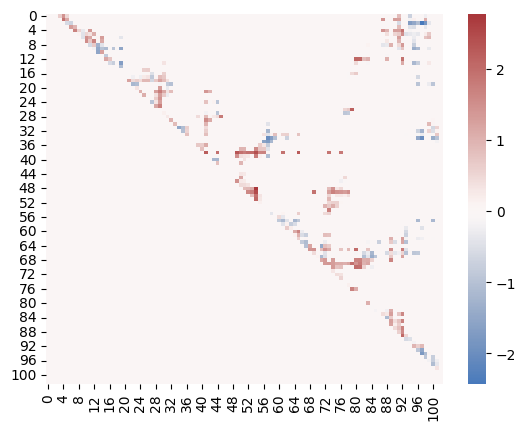

In [12]:
model=model_all

contact_map=np.triu(model.mask[:len(model.sequence),:len(model.sequence)])
pair_frustration=model.frustration('mutational')*contact_map
sns.heatmap(pair_frustration,cmap='vlag',center=0)

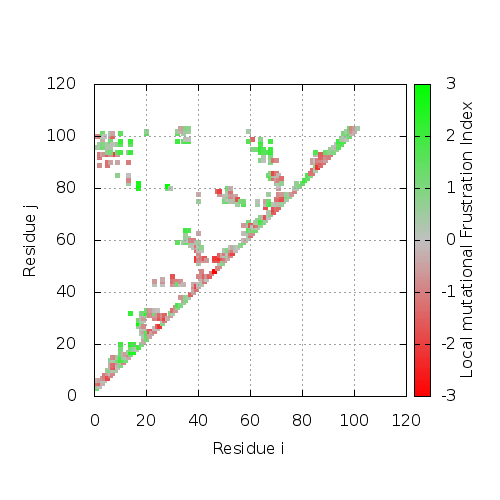

In [13]:
def view_frustration_(pdb_filename,model,contact_map):
    
    pair_frustration=model.frustration('mutational')*contact_map
    residues=np.arange(len(model.sequence))
    r1, r2 = np.meshgrid(residues, residues, indexing='ij')
    sel_frustration = np.array([r1.ravel(), r2.ravel(), pair_frustration.ravel()]).T
    minimally_frustrated = sel_frustration[sel_frustration[:, -1] < -0.78]
    frustrated = sel_frustration[sel_frustration[:, -1] > 1]
    
    
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    view.addModel(open(pdb_filename,'r').read(),'pdb')

    view.setBackgroundColor('white')
    view.setStyle({'cartoon':{'color':'white'}})
    


    for i,j,f in frustrated:
        view.addLine({'start':{'chain':'A','resi':[str(i+1)]},'end':{'chain':'A','resi':[str(j+1)]},
                      'color':'red', 'dashed':False,'linewidth':3})
    
    for i,j,f in minimally_frustrated:
        view.addLine({'start':{'chain':'A','resi':[str(i+1)]},'end':{'chain':'A','resi':[str(j+1)]},
                      'color':'green', 'dashed':False,'linewidth':3})

  
    view.zoomTo(viewer=(0,0))

    return view

In [14]:
view_frustration_(pdb_file_chain,model_all,
                  contact_map=np.triu(model_all.mask[:len(model_all.sequence),:len(model_all.sequence)]))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [23]:
#sns.heatmap(model_all.mask)

residues=np.arange(len(model_all.sequence))
pair_frustration=model_all.frustration('mutational')*contact_map

all_contacts=np.array([r1.ravel(), r2.ravel(), contact_map.ravel()]).T
all_contacts=all_contacts[all_contacts[:,2]==1]
len(all_contacts)

NameError: name 'r1' is not defined

In [24]:
frustra_table=pd.DataFrame(all_contacts)
frustra_table

NameError: name 'all_contacts' is not defined

In [22]:
r1, r2 = np.meshgrid(residues, residues, indexing='ij')
sel_frustration = np.array([r1.ravel(), r2.ravel(), pair_frustration.ravel()]).T
minimally_frustrated = sel_frustration[sel_frustration[:, -1] < -0.78]

s = np.argsort(minimally_frustrated[:, -1])
print(minimally_frustrated[s].shape)
minimally_frustrated = minimally_frustrated[s]

frustrated = sel_frustration[sel_frustration[:, -1] > 1]
#s = np.argsort(frustrated[:, -1])[::-1]
print(frustrated[s].shape)

frustrated = frustrated[s]


NameError: name 'residues' is not defined

In [17]:
path_bs=path_f+'pdb_files_'+bs_name+'/'
model_exon=dca_frustratometer.AWSEMFrustratometer(path_bs+'exon_0.pdb',
                                                  chain='A',sequence_cutoff=3,  distance_cutoff=10)


@> 173 atoms and 1 coordinate set(s) were parsed in 0.00s.


In [18]:
contact_map=np.triu(model_exon.mask)
pair_frustration=model_exon.frustration('mutational')*contact_map
sns.heatmap(pair_frustration,cmap='vlag',center=0)


IndexError: index 22 is out of bounds for axis 0 with size 22

In [38]:
len(model_exon.sequence)

23

# using the frustra server

In [40]:
def make_contact_col(frustra_all):
    frustra_all['contact']=frustra_all['#Res1'].astype(str)+frustra_all.AA1+'-'+frustra_all.Res2.astype(str)+frustra_all.AA2
    return frustra_all

In [41]:
fr_index_dict={'highly':2,'neutral':1,'minimally':0}
path_bs=path_f+'pdb_files_'+bs_name+'/'

In [42]:
frustra_all=pd.read_csv(path_bs+pdb_code+'_'+chain+'.pdb_mutational',sep=' ')
frustra_all=make_contact_col(frustra_all)
j=0
frustra_ex=pd.read_csv(path_bs+'exon_'+str(j)+'.pdb_mutational',sep=' ')
frustra_ex=make_contact_col(frustra_ex)


In [43]:
sum(frustra_all.FrstState=='highly')

94

In [44]:
frustra_all.

SyntaxError: invalid syntax (76895863.py, line 1)

In [45]:
fr_dif=frustra_ex.merge(frustra_all,on='contact')

In [46]:
fr_dif['fr_exon']=fr_dif.FrstState_x.map(fr_index_dict)
fr_dif['fr_all']=fr_dif.FrstState_y.map(fr_index_dict)

fr_dif['fr_dif']=-fr_dif['fr_all']+fr_dif['fr_exon']

In [47]:
fr_dif.groupby(['fr_dif','FrstState_x','FrstState_y']).Res2_x.count()/len(fr_dif)
# estos son solo los contactos internos del exon
# faltaria por otro lado los exon-resto

fr_dif  FrstState_x  FrstState_y
-1      minimally    neutral        0.040541
        neutral      highly         0.013514
 0      highly       highly         0.108108
        minimally    minimally      0.202703
        neutral      neutral        0.364865
 1      highly       neutral        0.162162
        neutral      minimally      0.108108
Name: Res2_x, dtype: float64

In [48]:

def view_frustration(pdb_filename,frustra_table):
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    view.addModel(open(pdb_filename,'r').read(),'pdb')

    view.setBackgroundColor('white')
    view.setStyle({'cartoon':{'color':'white'}})
    
    fr_index_dict={'highly':2,'neutral':1,'minimally':0}
    frustra_color=['green','blue','red']
    frustra_num=frustra_table.FrstState.map(fr_index_dict)

    for x in range(len(frustra_table)):
        if frustra_num[x]!=1:
            view.addLine({'start':{'chain':'A','resi':[str(frustra_table['#Res1'][x])]},
                          'end':{'chain':'A','resi':[str(frustra_table['Res2'][x])]},
              'color':frustra_color[frustra_num[x]], 'dashed':False,'linewidth':3})
  
    view.zoomTo(viewer=(0,0))

    return view

In [49]:
view_frustration(pdb_file_chain,frustra_all)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [50]:
view_frustration(path_bs+'exon_0.pdb',frustra_ex)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [51]:

def view_frustration_dif(pdb_filename_all,pdb_filename_exon,frustra_table):
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    view.addModel(open(pdb_filename_all,'r').read(),'pdb')

    view.setBackgroundColor('white')
    view.setStyle({'cartoon':{'color':'white'}})
    
    for res in np.unique(np.hstack([fr_dif['#Res1_x'],fr_dif.Res2_x])):
        view.addStyle({'chain':'A','resi':[str(res)]},{'cartoon':{'color':'grey'}})
    
    #OJO SI HAY UN -2 O +2 LO ROMPO, CORREGIR
    frustra_color=['red','blue','green'] # worse, equal, better 
    frustra_num=frustra_table.fr_dif

    for x in range(len(frustra_table)):
        if frustra_num[x]!=0:
            view.addLine({'start':{'chain':'A','resi':[str(frustra_table['#Res1_x'][x])]},
                          'end':{'chain':'A','resi':[str(frustra_table['Res2_x'][x])]},
             'color':frustra_color[frustra_num[x]+1], 'dashed':False,'linewidth':3})
  
    view.zoomTo(viewer=(0,0))

    return view

In [52]:
view_frustration_dif(pdb_file_chain,path_bs+'exon_0.pdb',fr_dif)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# considering also contacts exon-other parts

In [53]:
exon_res=np.unique(np.hstack([frustra_ex['#Res1'],frustra_ex.Res2]))
ix=[]
for i in exon_res:
    ix.append(frustra_all.index[frustra_all['#Res1']==i])
    ix.append(frustra_all.index[frustra_all['#Res1']==j])
ix_=np.unique(np.hstack(ix))
fr_all_ex=frustra_all.loc[ix_].reset_index()
fr_index_dict2={'highly':1,'neutral':0,'minimally':-1}
fr_all_ex['fr_dif']=fr_all_ex.FrstState.map(fr_index_dict2) #this way is comparable with the other result

fr_dif2=fr_all_ex.merge(frustra_ex,on='contact',how='left')
fr_dif2['fr_exon']=fr_dif2.FrstState_y.map(fr_index_dict)
fr_dif2['fr_all']=fr_dif2.FrstState_x.map(fr_index_dict)

for x in range(len(fr_dif2)):
    if ~np.isnan(fr_dif2['fr_exon'][x]):
        fr_dif2.fr_dif[x]=-fr_dif2['fr_all'][x]+fr_dif2['fr_exon'][x]
    

/tmp/ipykernel_57087/3890593972.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr_dif2.fr_dif[x]=-fr_dif2['fr_all'][x]+fr_dif2['fr_exon'][x]


In [54]:
fr_dif2.groupby(['fr_dif','FrstState_x','FrstState_y']).Res2_x.count()/len(fr_dif)

fr_dif  FrstState_x  FrstState_y
-1      highly       neutral        0.013514
        neutral      minimally      0.040541
 0      highly       highly         0.108108
        minimally    minimally      0.202703
        neutral      neutral        0.364865
 1      minimally    neutral        0.108108
        neutral      highly         0.162162
Name: Res2_x, dtype: float64

In [55]:
view_frustration_dif(pdb_file_chain,path_bs+'exon_0.pdb',fr_dif2)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol